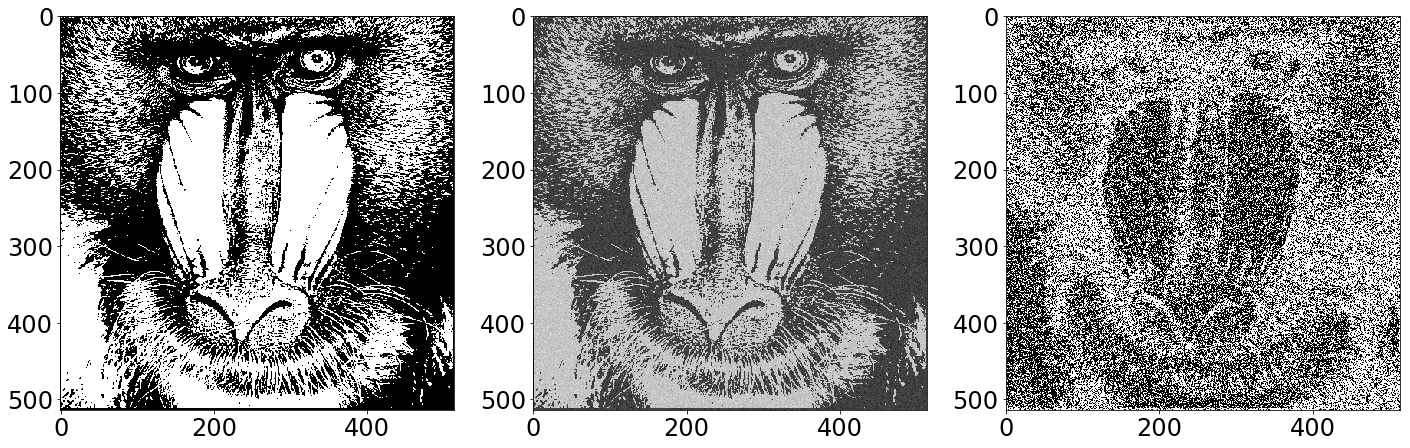

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from imageio import imread

pylab.rcParams['figure.figsize'] = (24.0, 24.0)
pylab.rcParams['font.size'] = 24

def add_gaussian_noise(im, prop, varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im)
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]   
    return im2

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

# proportion of pixels to alter
prop = 0.7
varSigma = 0.1

#Grayscaling the image
im = rgb2gray(imread('Graphics/stan_lee.png'))

'''
im_temp = rgb2gray(imread('Graphics/stan_lee.png'))

#Padding the image with 0's so that the finding neighbours algorithm runs faster.
im = np.zeros((514,514))
for i in range (len(im_temp[0])):
    for j in range (len(im_temp[1])):
        im[i+1][j+1] = im_temp[i][j]    
'''

#Thresholding the image at 50%
im = np.array([np.round(x/255) for x in im])


fig = plt.figure()

#Image with no noise
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')

#Image with Gaussian noise
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

#Image with salt and peper noise
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')

plt.show()

In [16]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1, N-1)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2, N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        
        return n
    if size==8:
        n = [(i-1, j), (i-1, j-1), (i-1, j+1), (i, j-1), (i, j+1), (i+1, j), (i+1,j-1), (i+1,j+1)]
        n = [(x, y) for (x, y) in n if 0 <= x <= M - 1 and 0 <= y <= N - 1]
        return n


'''    
# optimised neighbourhood function (with padding)
def neighbours (i,j,M,N,size):
    if size==4:
        n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        n = [(i-1,j), (i+1,j), (i,j-1), (i,j+1), (i-1,j-1), (i-1,j+1), (i+1,j-1), (i+1, j+1)]
        return n
    return -1
'''

In [17]:
def Li(x, y):
    return np.exp(-(x - y)**2)

In [18]:
def p(x, y, w, M, N):
    prod = 1
    for i in range(0, M - 1):
        for j in range(0, N - 1):
            acc = 0
            for n in neighbours(i, j, M, N, size = 8):
                acc += w[i][j][n[0]][n[1]] * x[i][j] * x[n[0]][n[1]]
            esum = np.exp(acc)
            
            prod *= np.exp(Li(x[i][j], y[i][j])) * esum
    return prod

In [19]:
def image_denois_ICM(x0, y, T, M, N, beta, eta):
    x = x0
    
    nsum = 0
    xysum = 0
    for i in range(0, M - 1):
        for j in range(0, N - 1):
            xysum += x[i][j] * y[i][j] 
            for (a, b) in neighbours(i, j, M, N, size = 8):
                nsum += x[i][j] * x[a][b]
                
    for t in range(0, T):        
        for i in range(0, M - 1):
            for j in range(0, N - 1):
                for (a,b) in neighbours(i, j, M, N, size = 8):
                    nsum += x[a][b] - (x[i][j]  * x[a][b])
                xysum += y[i][j] - x[i][j] * y[i][j]
                pp = beta * nsum + eta * xysum
                
                for (a,b) in neighbours(i, j, M, N, size = 8):
                    nsum -= 2 * x[a][b]
                xysum -= 2 * y[i][j]
                pn = beta * nsum + eta * xysum
                
                if pp > pn:
                    for (a,b) in neighbours(i, j, M, N, size = 8):
                        nsum += 2 * x[a][b] 
                    xysum += 2 * y[i][j]
                    x[i][j] = 1
                else:
                    x[i][j] = -1
    return x
                
                

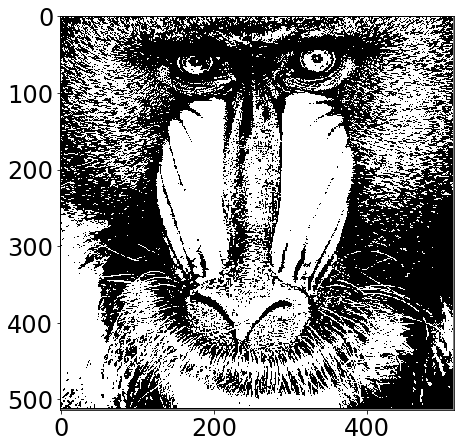

In [29]:
y = im2
y = 2*y - 1

(M, N) = y.shape
x = image_denois_ICM(np.zeros((M, N)), y, 1, M, N, beta = 0, eta = 1)

fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(x,cmap='gray')


plt.show()